In [1]:
import shap
from data import X_train, Y_train, X_valid, Y_valid, treatment_col, column_names
from model import train_xgb_model, train_logistic, simple_network, evaluate_uplift
from pylift.eval import UpliftEval
import matplotlib

xgbmodel = train_xgb_model(X_train, Y_train, X_valid, Y_valid)

#upev = UpliftEval(X_valid[:, treatment_col], xgbmodel.predict_proba(treatment_col))
#nmodel = simple_network(X_train, Y_train, X_valid, Y_valid)
#logmodel = train_logistic(X_train, Y_train, X_valid, Y_valid)


# plot importance
#explainer = shap.TreeExplainer(xgbmodel)
#xg_shap_values = explainer.shap_values(X_train.iloc[:100, :])
#shap.force_plot(explainer.expected_value, xg_shap_values[0, :], X_train.iloc[0, :], matplotlib=True)
#shap.summary_plot(xg_shap_values, X_train.iloc[:100, :], feature_names=list(X_train.columns))

print("train gain={}".format(evaluate_uplift(xgbmodel, X_train, Y_train, treatment_col, plot=True)))
print("valid gain={}".format(evaluate_uplift(xgbmodel, X_valid, Y_valid, treatment_col, plot=True)))

XGBoost train score: 0.875546875
XGBoost valid score: 0.84734375
train gain=0.7190484104514848
valid gain=0.02037420658358888


# Shapley

In [2]:
xgbmodel_predict=lambda x: xgbmodel.predict_proba(x)[:,1]

In [3]:
import numpy as np
np.random.seed(123)

In [4]:
# obserwacja nr 2
obs2 = X_valid[2,:]

In [19]:
def predict_treatment(c):
    def pred(x):
        x=x.copy()
        x[:, treatment_col]=c
        return xgbmodel.predict_proba(x)[:,1]
    return pred

In [20]:
def shapley_single (model_predict, obs):
    explainer = shap.KernelExplainer(model_predict, shap.sample(X_valid, 100))
    #shap.TreeExplainer(xgbmodel, model_output='probability', data=shap.sample(X_valid,100))
    shap_values = explainer.shap_values(obs) 
    plot = shap.waterfall_plot(explainer.expected_value, shap_values,
                                   feature_names=column_names)
    return shap_values, explainer.expected_value

In [23]:
def shapley_diff(model_predict, obs):
    
    shap_T0, exp0 =shapley_single(predict_treatment(0), obs)
    shap_T1, exp1 =shapley_single(predict_treatment(1), obs)
    plot = shap.waterfall_plot(exp1 - exp0, shap_T1-shap_T0,
                                   feature_names=column_names)
    
    return (shap_T1-shap_T0, exp1 - exp0)

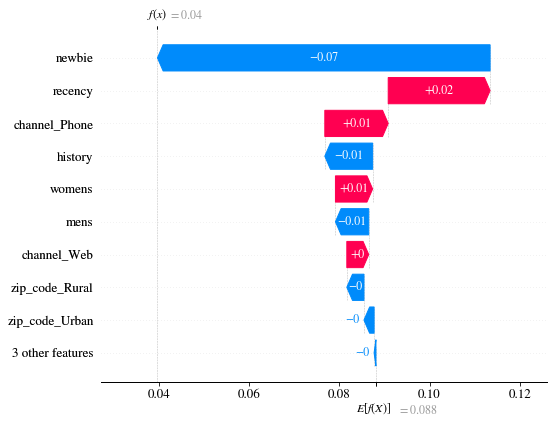

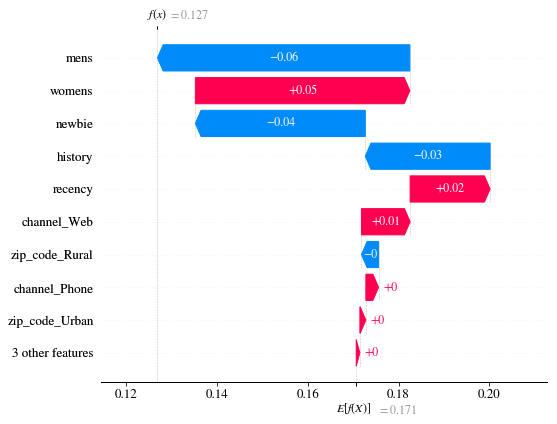

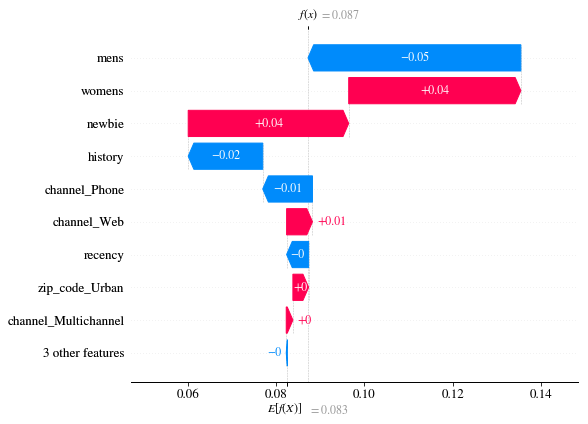

(array([-4.98411753e-03, -1.68750551e-02, -4.81898555e-02,  3.89748074e-02,
        -1.22670597e-04,  3.86954038e-05,  3.56109872e-03,  3.63393698e-02,
        -1.12600253e-02,  5.85568510e-03,  1.50625964e-03, -1.66715967e-04]),
 0.08256734008435158)

In [24]:
shapley_diff(xgbmodel_predict, obs2)

# Uplift model

In [16]:
def uplift(model, x, treatment_col=treatment_col):
    x_ones = x.copy()
    x_zeros = x.copy()
    x_ones[:, treatment_col] = 1
    x_zeros[:, treatment_col] = 0

    uplift = (model.predict_proba(x_ones) - model.predict_proba(x_zeros))[:, 1]
    return uplift

In [17]:
uplift_predict=lambda x: uplift(xgbmodel, x).astype(float)

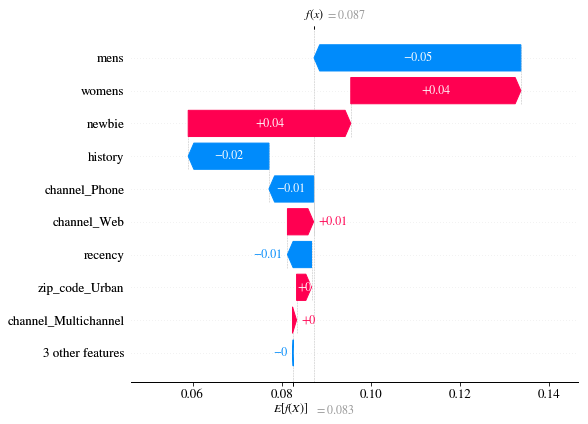

(array([-5.39682575e-03, -1.81005085e-02, -4.63686078e-02,  3.81337461e-02,
         8.06005220e-04, -8.57518554e-04,  3.35090869e-03,  3.64456583e-02,
        -1.00150256e-02,  5.86524520e-03,  9.05909043e-04, -9.15101243e-05]),
 0.08256733975373208)

In [26]:
shapley_single(uplift_predict, obs2)

# issues:
- shapley values in the two methods are different

In [ ]:
shapley_single(uplift_predict, obs2)